In [2]:
import numpy as np
import os
import numpy.ma as ma
import matplotlib.pyplot as plt
from astropy.io import fits
import meta_variables as mv
import constants_and_functions as cf
import manipulate_text as mt
from scipy.interpolate import interp2d

In [3]:
this_path = os.getcwd()
base_path = this_path.split('scripts')[0]
file_name = 'compare_dchi_ringvsnoring__numsamps_500_D0_3e+28_mask_thicknesses_5.52e-03_9.65e-03_sigmav_logspace_-27_-24_80_mx_logspace_6_500_20.npy'
fits_path = base_path.split('Secondary_radiation')[0] + 'synchrotron_data/'
fits_name = 'm31cm3nthnew.ss.90sec.fits'
sync_path = base_path + 'synchrotron_emission/'

compare_masks = np.load(base_path + 'stat_results/' + file_name)
compare_masks = compare_masks/2

In [18]:
compare_masks = np.load(base_path + 'stat_results/' + file_name) 
compare_masks = compare_masks/2
np.save(base_path + 'stat_results/' + file_name, compare_masks)

In [19]:
print(compare_masks)

[82.31433308 51.29201636 97.52207907 43.18778943 20.58086349  9.54173106
  2.33247927  1.11714331  1.2457189   2.04938709]


In [4]:
def f(x, w):
    elliptic_d = np.sqrt(x[0]**2+w[2]*x[1]**2)
    return w[0]+w[1]*np.exp(-(elliptic_d-w[3])**2/(2*w[4]))

def get_data_and_info(fits_path, fits_name):
    #extract data and information about data
    hdul = fits.open(fits_path+fits_name)
    data_uJ = hdul[0].data[0]
    data = data_uJ/1000 #mJ/beam
    hdr = hdul[0].header
    dlt_N_deg = abs(hdr['CDELT1'])
    dlt_n_deg = abs(hdr['CDELT2'])
    N = hdr['NAXIS1']
    n = hdr['NAXIS2']
    nu_data = hdr['CRVAL3']
    nu_BW = hdr['CDELT3']
    HPBW_deg = hdr['BMIN']
    return data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW

def make_coords(N, n, dlt_N, dlt_n, loc='centered'):
    if loc=='centered':
        ax_N_unit = np.linspace(-(N-1)/2, (N-1)/2, N)
        ax_n_unit = np.linspace(-(n-1)/2, (n-1)/2, n)
    elif loc=='edges':
        ax_N_unit = np.linspace(-N/2, N/2, N+1)
        ax_n_unit = np.linspace(-n/2, n/2, n+1)
    return dlt_N*ax_N_unit, dlt_n*ax_n_unit

#coords = (x, y)
#ellipse_params = (r2, a, thickness/2)
def create_mask(THETA, th_range, coords=None, ellipse_params=None, data=None,  sigma_rms=None, num_sigma_rms=None, sigma_BW=None, num_sigma_BW=None, dlt=None, method='azimuthally_sym'):
    if method=='azimuthally_sym':
        return np.logical_and(THETA>th_range[0], THETA<th_range[1])
    elif method=='ellipse_and_azimuthally_sym':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
        elliptic_d = np.sqrt(coords[0]**2+ellipse_params[0]*coords[1]**2)
        m2 = np.abs(elliptic_d-ellipse_params[1])>ellipse_params[2]
        return m1*m2


In [24]:
print(mask_thicknesses)
print(compare_masks)

[0.00552    0.00597889 0.00643778 0.00689667 0.00735556 0.00781444
 0.00827333 0.00873222 0.00919111 0.00965   ]
[82.31433308 51.29201636 97.52207907 43.18778943 20.58086349  9.54173106
  2.33247927  1.11714331  1.2457189   2.04938709]


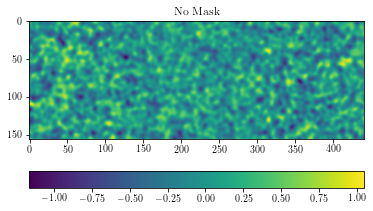

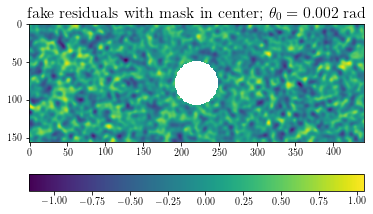

In [10]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW = get_data_and_info(fits_path, fits_name)
dlt_N = dlt_N_deg*np.pi/180
dlt_n = dlt_n_deg*np.pi/180
ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
AX_N, AX_n = np.meshgrid(ax_N, ax_n)
THETA = np.sqrt(AX_N**2+AX_n**2)
th_range = [0.002, np.pi]
#mask_thicknesses = np.linspace(5.52e-3, 9.65e-3, 10)
mask_thicknesses = np.array([0])
ellipse_params_in = [1.18664897, 1.90411181e1, 1.43380938e-2,  9.62516799e-6]
w_best = [0]+ ellipse_params_in
resid = np.load(base_path + 'fake_resid_new/' + 'sigma_rms_0.25_0.3_spacing_2.69e-05_samplenum_54.npy')
fake_data = resid
minmin = np.min(fake_data)
maxmax = np.max(fake_data)
fig = plt.figure()
plt.imshow(fake_data, vmin=minmin, vmax=maxmax)
plt.title(r'No Mask')
plt.colorbar(orientation='horizontal')
mask_set = []
for thickness in mask_thicknesses:
    this_mask = create_mask(THETA, th_range, coords=(AX_N, AX_n), ellipse_params=(ellipse_params_in[1], ellipse_params_in[2], thickness), method='ellipse_and_azimuthally_sym')
    mask_set.append(this_mask)
    ma_data = ma.array(fake_data, mask = np.logical_not(this_mask))
    fig=plt.figure()
    plt.imshow(ma_data, vmin=minmin, vmax=maxmax)
    plt.title(r'fake residuals with mask in center; $\theta_0 = 0.002\; \mathrm{rad}$', size=16)
    plt.colorbar(orientation = 'horizontal')
    plt.savefig(base_path + 'figs/resid_with_centermask.pdf')
    

In [25]:
HPBW_deg = 1.5/60
HPBW = HPBW_deg*np.pi/180
sigma_BW = HPBW/(2*np.sqrt(2*np.log(2)))
omega_beam = 2*np.pi*sigma_BW**2
print(omega_beam)

2.1572435186680006e-07


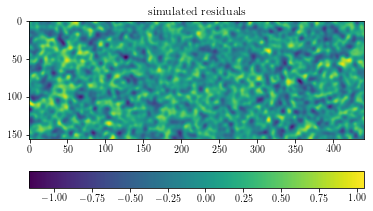

In [28]:
plt.imshow(resid)
plt.title('simulated residuals')
plt.colorbar(orientation='horizontal')
plt.savefig(base_path + 'figs/fake_residuals.pdf')

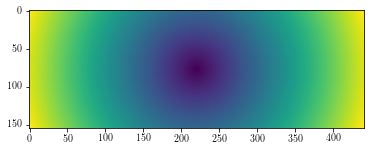

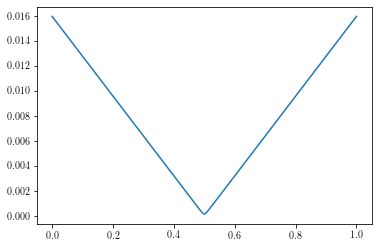

In [39]:
plt.imshow(THETA)
fig = plt.figure()
plt.plot(np.linspace(0, 1, 441), THETA[75])

this_path = /het/p4/mjw283/eventgen_wd/Secondary_radiation/scripts/manipulate_text.py
['0009_synchrotron_emission.npy']


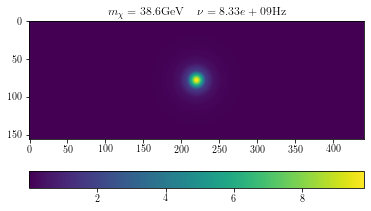

In [42]:
mx_ar = np.array([38.6])
D0_ar = np.array([3e28])
runs = mt.find_results(2, mx=mx_ar, D0=D0_ar)
inds = []
for run in runs:
    this_D0 = run['D0']
    this_ind = np.where(D0_ar==this_D0)[0][0]
    inds.append(this_ind)
p = np.argsort(inds)
file_names = [runs[arg]['file_name'].split('_info')[0] + '.npy' for arg in p]
print(file_names)
DA = runs[0]['DA']
nrho = runs[0]['nrho']
nnu = runs[0]['nnu']
rho_range = runs[0]['rho_range']
nu_range = runs[0]['nu_range']
nu_v = np.logspace(np.log10(nu_range[0]), np.log10(nu_range[1]), nnu)
rho_v = np.linspace(rho_range[0], rho_range[1], nrho)
theta_v = np.arcsin(rho_v/np.sqrt(rho_v**2+DA**2))
thetatheta, nunu = np.meshgrid(theta_v, nu_v)
nu_set = np.array([cf.c/3.6])
f_plt = np.zeros((len(D0_ar)*len(nu_set), nrho))
row = 0
for i in range(len(D0_ar)):
    nudSdnudth = np.load(sync_path + file_names[i])
    dS_dnudOmega = ((10**26/nunu)*nudSdnudth/(2*np.pi*np.sin(thetatheta))).astype(np.float64) #mJy/Sr
    dS_dnuperbeam = dS_dnudOmega*omega_beam
    max_nonzero = dS_dnuperbeam.shape[0]
    inds = np.where(dS_dnuperbeam==0)[0]
    if len(inds)>0:
        max_nonzero = np.min(inds)
    flux_interp = interp2d(thetatheta[0], nunu[:max_nonzero, 0], dS_dnuperbeam[:max_nonzero, :])
    
    for nu in nu_set:
        signal = np.array([[flux_interp(THETA[i, j], nu) for j in range(THETA.shape[1])] for i in range(THETA.shape[0])])
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure()
plt.imshow(signal)
plt.title(r'$m_\chi = 38.6 \mathrm{GeV} \;\;\;\; \nu = '+ '{:.2e}'.format(nu) +r'\mathrm{Hz}$')
plt.colorbar(orientation='horizontal')
plt.savefig(base_path + 'figs/signal_image.pdf')

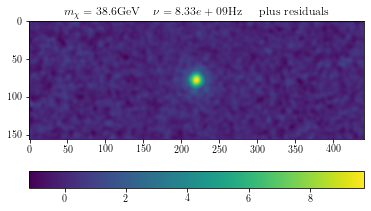

In [46]:
plt.imshow(resid+signal[:, :, 0])
plt.title(r'$m_\chi = 38.6 \mathrm{GeV} \;\;\;\; \nu = '+ '{:.2e}'.format(nu) +r'\mathrm{Hz} \;\;\;\;$ plus residuals')
plt.colorbar(orientation='horizontal')
plt.savefig(base_path + 'figs/signal_plus_resid_image.pdf')